In [1]:
from datasets import load_dataset
import pandas as pd
import re
import matplotlib.pyplot as plt
import requests, zipfile, io
import os
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers.models.m2m_100.modeling_m2m_100 import M2M100ForConditionalGeneration

c:\Users\Stephan\anaconda3\envs\chatbot-text_classification\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
def load_questions_dataset():
    """Loads questions from germanquad dataset (https://huggingface.co/datasets/deepset/germanquad)
    """
    data = load_dataset("deepset/germanquad", split="train")

    #TODO remove 50% of the question marks ? (maybe BERT focuses on questionmarks)
    questions = pd.DataFrame(data)[["question"]]
    questions.columns = ["text"] #rename

    return questions

def load_offensive_dataset():
    """Loads offensive text from germeval18 dataset (https://huggingface.co/datasets/philschmid/germeval18)
    Also includes some preprocessing steps like Username removal, removal of emojis and replacement of 'ß' with 'ss'
    """
    
    data = load_dataset("philschmid/germeval18", split="train")

    #convert to pandas dataframe
    germeval18 = pd.DataFrame(data)

    #regex for preprocessing
    match = re.compile(r'[^a-zA-Z\säßüö\"\'.!?]', flags=re.UNICODE)
    def preprocessing(text:str):
        """Removes username calling (@Username), only allows text, punktucation, double quote, single quote and replaces 'ß' with 'ss'
        """

        return match.sub(u'', str.join(" ", [word.replace("ß", "ss") for word in text.split(" ") if not str.startswith(word, "@")]))

    #only select offensive overvations and also only text column
    offensive = germeval18[germeval18.binary == "OFFENSE"][["text"]]
    offensive.columns = ["text"] #rename

    #apply preprocessing
    offensive["text"] = offensive.text.apply(preprocessing)

    return  offensive

def load_concern_dataset():
    """ Loads SAD dataset from(https://github.com/PervasiveWellbeingTech/Stress-Annotated-Dataset-SAD)
    Only take school related concern text.
    """

    #load 
    r = requests.get("https://raw.githubusercontent.com/PervasiveWellbeingTech/Stress-Annotated-Dataset-SAD/main/SAD_v1.zip")
    z = zipfile.ZipFile(io.BytesIO(r.content))

    #extract excel file from zip
    filename = z.extract("SAD_v1.xlsx")

    #read excel file
    data = pd.read_excel(filename)

    #delete excel file
    os.remove(filename)

    #filter for "School"
    concern = data[data.top_label == "School"][["sentence"]].reset_index(drop=True, inplace=False)
    concern.columns = ["text"] #rename

    return concern

def sampler(dfs:list, min_max_bins:tuple, train_split:float=0.8, seed=None):
    bins = pd.interval_range(start=min_max_bins[0], end=min_max_bins[1], freq=None, periods=min_max_bins[2], closed='right')
    intervals_list = [pd.cut(df.text.apply(lambda x: len(x.split())), bins) for df in dfs]

    # Calculate the minimum counts for each interval across all dataframes
    min_counts = intervals_list[0].value_counts()
    for intervals in intervals_list[1:]:
        current_counts = intervals.value_counts()
        min_counts = pd.concat([min_counts, current_counts], axis=1).min(axis=1)

    # Group each dataframe by their intervals
    grouped_list = [df.groupby(intervals, observed=True) for df, intervals in zip(dfs, intervals_list)]
    
    results = []
    for df, df_grouped in zip(dfs, grouped_list):
        df_sampled_train = []
        df_sampled_test = []

        for interval, min_count in min_counts.items():
            if interval in df_grouped.groups:
                df_sampled = df_grouped.get_group(interval).sample(n=min_count, random_state=seed)

                df_train = df_sampled.sample(frac=train_split, random_state=seed)
                df_test = df_sampled.drop(df_train.index)

                df_sampled_train.append(df_train)
                df_sampled_test.append(df_test)

        results.append((pd.concat(df_sampled_train, ignore_index=True), pd.concat(df_sampled_test, ignore_index=True)))

    return results

class Translate_en_ger():
    def __init__(self, device:str="cuda:0", max_length:int=50) -> None:
        """Translates a list of text from english to german. Uses the (nllb-200-distilled-1.3B) model
        Args:
            device (str): device to run the model on
            max_length (int): generate text until max length (not sure?)
        """
        # Model: https://huggingface.co/docs/transformers/model_doc/nllb & https://huggingface.co/facebook/nllb-200-distilled-1.3B
        # This model performed best in comparison with (https://huggingface.co/facebook/nllb-200-distilled-600M, https://huggingface.co/t5-base, https://huggingface.co/facebook/mbart-large-50-many-to-many-mmt) in a qualitative view
        # Model Size is also restrited due to limiations of gpu memory
        self.device = device
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-1.3B", fast=True)
        self.model:M2M100ForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-1.3B", device_map=device)

    def translate(self, data_en:list):
        """Translates a list of texts from english to german
        Args:
            data_en (list): list of english texts

        Returns:
            list of translated texts
        """

        inputs = self.tokenizer(data_en, padding=True, return_tensors="pt").to(self.device)

        translated_tokens = self.model.generate(
            **inputs, 
            forced_bos_token_id=self.tokenizer.lang_code_to_id["deu_Latn"], 
            max_length=self.max_length
        )

        return self.tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)

In [22]:
questions = load_questions_dataset()

questions

,text
0,Von welchem Gesetzt stammt das Amerikanische ab?
1,Warum unterscheidet sich das amerikanische Rec...
2,Wie viele ethnische Gruppen und indigenen Völk...
3,Woher kommt die Sexuelle Orientierung von Mens...
4,Seit wann gehört Guam zu dem Gebiet der Verein...
...,...
11513,Welchem Staat wurde Eritrea nach dem Zweiten W...
11514,In welchem Jahr annektierte Haile Selassie Eri...
11515,Wie lange dauerte der Unabhängigkeitskampf in ...
11516,Wann endete der Kampf um die Unabhängigkeit Er...


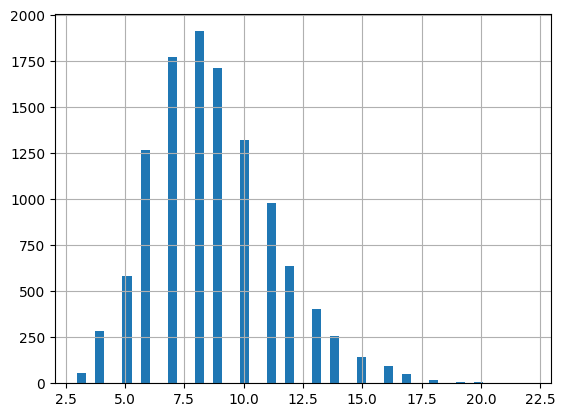

In [23]:
questions.text.apply(lambda x: len(x.split(" "))).hist(bins=50)
plt.show()

In [25]:
offensive = load_offensive_dataset()

offensive

,text
4,kein verlässlicher Verhandlungspartner. Nachka...
6,bis habe ich noch gar nicht gelebt und es ge...
8,Euere AfD Hetze wirkt. Da könnt ihr stolz sein...
9,Deutsche Medien Halbwahrheiten und einseitige ...
11,Oman Ralle..dich mag ja immer noch keiner. Du ...
...,...
4993,Diese absolute Unfähigkeit ...schleicht sich d...
4994,Das Deutsche Kaiserreich soll wieder auferstehen
5005,Zu Merkel fällt mir nur ein ein Mal Verräterin...
5006,Ein richtiges Zeichen unserer Nachbarn...schle...


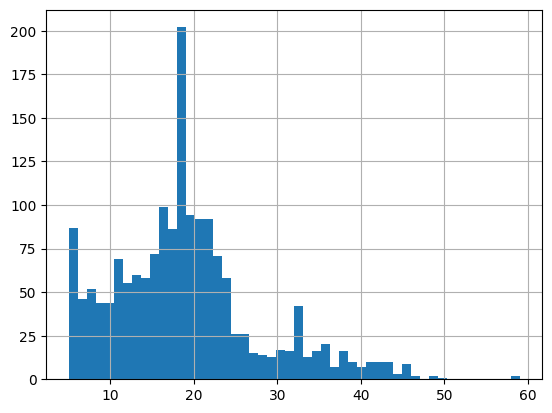

In [26]:
offensive.text.apply(lambda x: len(x.split(" "))).hist(bins=50)
plt.show()

<Axes: >

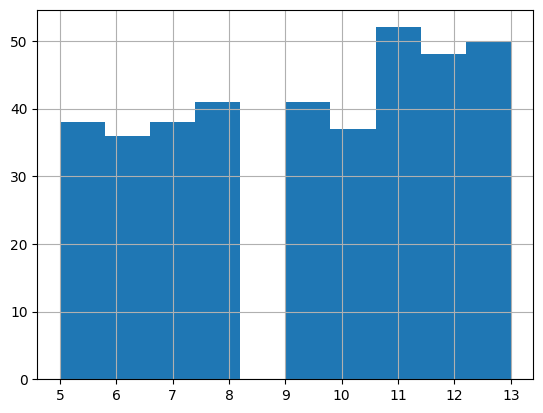

<Axes: >

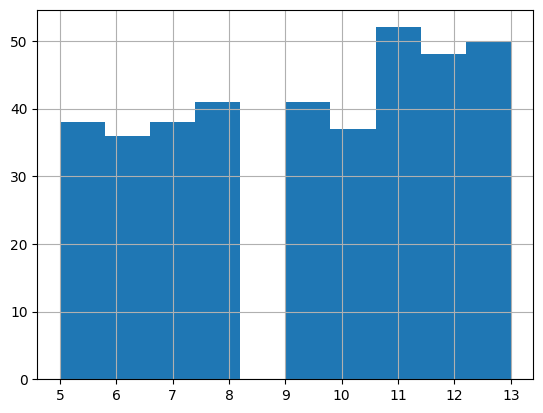

<Axes: >

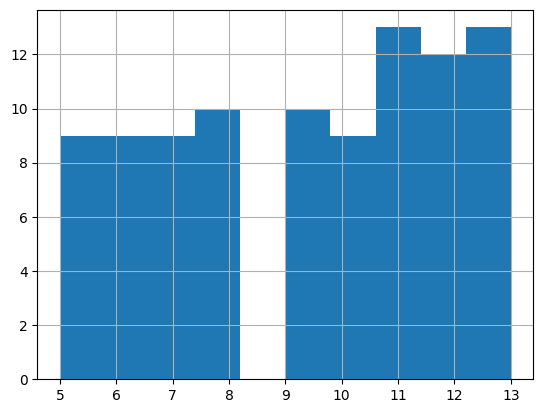

<Axes: >

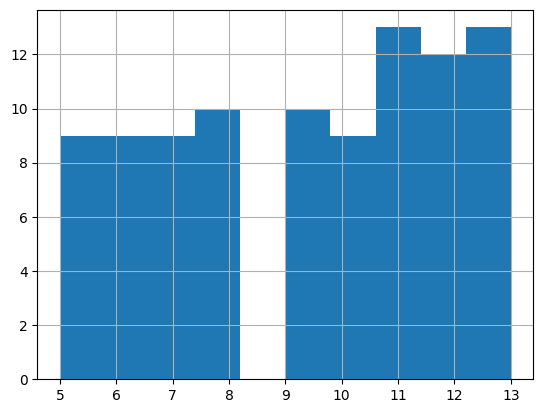

In [55]:
(sampled_df1_train, sampled_df1_test), (sampled_df2_train, sampled_df2_test) = sampler([questions, offensive], (3, 13, 10))

display(sampled_df1_train.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()
display(sampled_df2_train.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()
display(sampled_df1_test.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()
display(sampled_df2_test.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()

In [31]:
concern = load_concern_dataset()

concern

,text
0,a paper i need to write
1,a professor is driving me crazy.
2,Adjusting to distance learning for graduate le...
3,All of my classes being online and my roommate...
4,All of my classes moving online
...,...
738,"i have to worry about college, and school sta..."
739,"Because of all my emotional burdens, I have be..."
740,I'm scared I'm not going to be able to handle ...
741,"I can't make it through school, I cause my fam..."


In [34]:
concern["text"] = Translate_en_ger().translate(concern.text.to_list())

concern

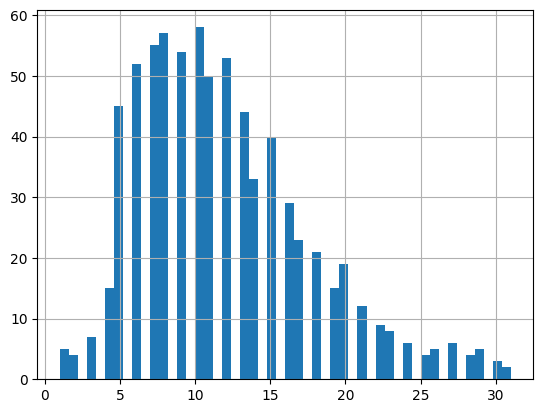

In [45]:
concern.text.apply(lambda x: len(x.split(" "))).hist(bins=50)
plt.show()

<Axes: >

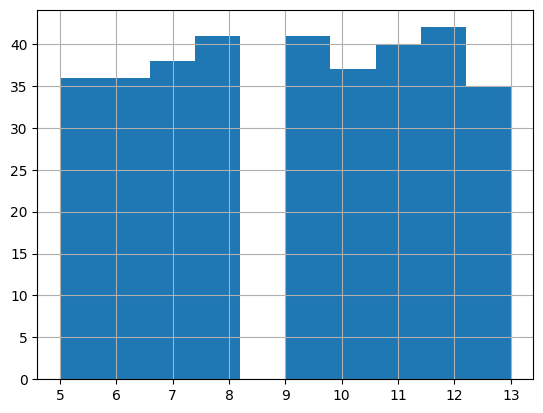

<Axes: >

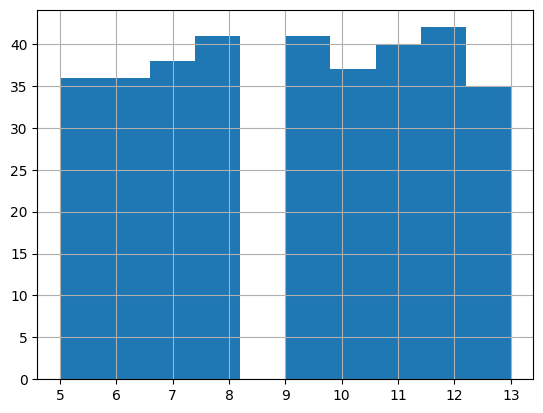

<Axes: >

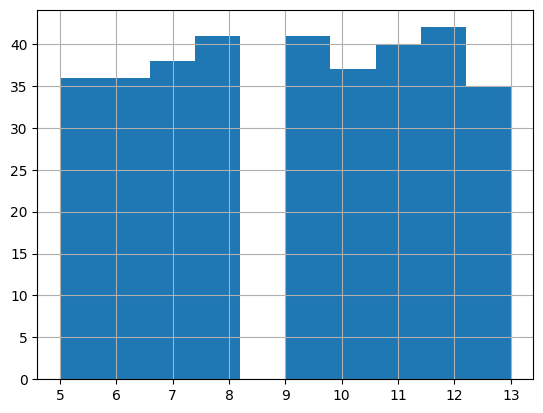

<Axes: >

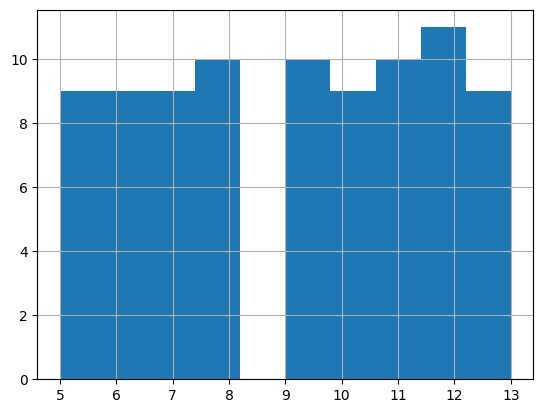

<Axes: >

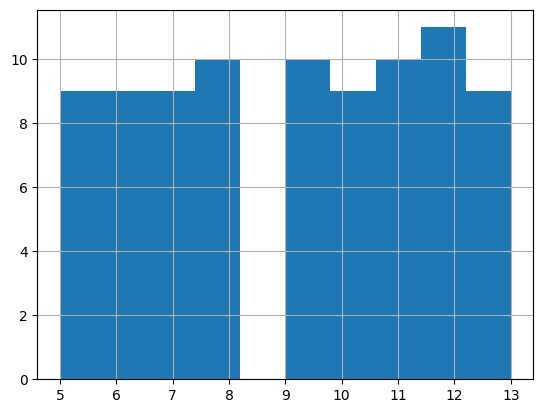

<Axes: >

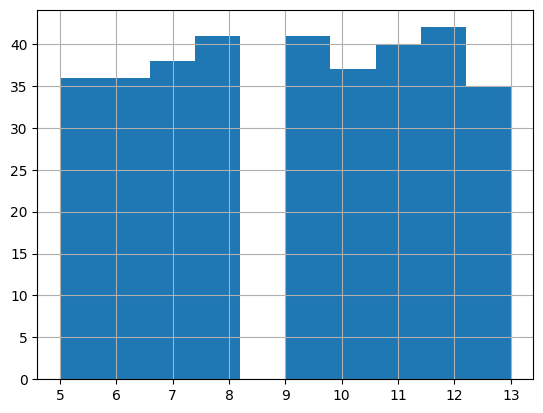

In [56]:
(sampled_df1_train, sampled_df1_test), (sampled_df2_train, sampled_df2_test), (sampled_df3_train, sampled_df3_test) = sampler([questions, offensive, concern], (3, 13, 10))

display(sampled_df1_train.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()
display(sampled_df2_train.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()
display(sampled_df3_train.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()
display(sampled_df1_test.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()
display(sampled_df2_test.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()
display(sampled_df3_train.text.apply(lambda x: len(x.split())).hist(bins=10))
plt.show()

In [50]:
sampled_df3_train

,text
0,Der Unterricht ist langweilig.
1,Die Klasse ist schrecklich.
2,Klassen in meinem College
3,Die Schule war hart.
4,Schule ist so langweilig!
...,...
381,Ich habe in fünf Tagen ein großes Schulprojekt...
382,"Ich habe mir nur Sorgen gemacht, ob ich meinen..."
383,"Ich habe kein Geld für das Sommersemester, als..."
384,Ich war mit der Schule beschäftigt und war fas...


<Axes: >

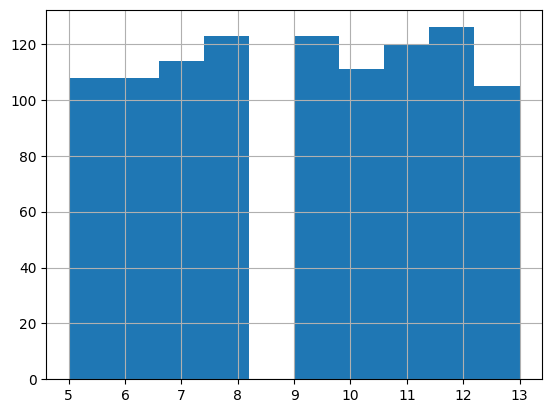

In [13]:
pd.read_parquet("./data/train.parquet").text.apply(lambda x: len(x.split())).hist()

<Axes: >

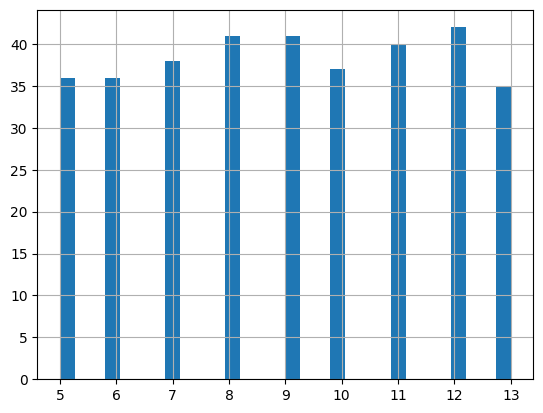

In [16]:
df = pd.read_parquet("./data/train.parquet")
df[df.label=="question"].text.apply(lambda x: len(x.split())).hist(bins=30)

<Axes: >

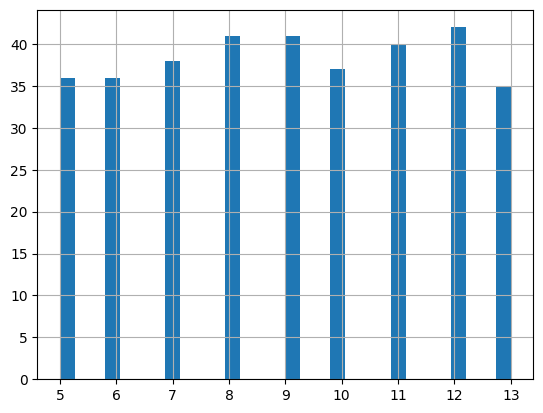

In [17]:
df = pd.read_parquet("./data/train.parquet")
df[df.label=="other"].text.apply(lambda x: len(x.split())).hist(bins=30)

<Axes: >

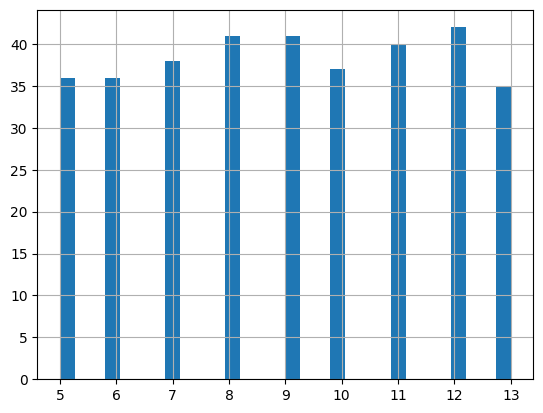

In [18]:
df = pd.read_parquet("./data/train.parquet")
df[df.label=="concern"].text.apply(lambda x: len(x.split())).hist(bins=30)